In [18]:
import os
import sys
import requests
import pandas as pd
import numpy as np
import QuantLib as ql
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import product
from datetime import datetime
from datetime import timedelta
from model_settings import ms
from historical_av_plot_vol_surface import plot_vol_surface
fontsize=6
plt.rcParams.update(
    {
        'axes.labelsize': fontsize,
        'xtick.labelsize': fontsize,
        'ytick.labelsize': fontsize,
        'figure.titlesize': fontsize,
        'axes.linewidth': 1/3,
    }
)
search_symbol = 'USD'
url = f"https://www.alphavantage.co/query?function=SYMBOL_SEARCH&keywords={search_symbol}&apikey={ms.av_key}"
r = requests.get(url)
data = r.json()
pd.DataFrame(data['bestMatches'])

,1. symbol,2. name,3. type,4. region,5. marketOpen,6. marketClose,7. timezone,8. currency,9. matchScore
0,USD,PROSHARES ULTRA SEMICONDUCTORS,ETF,United States,09:30,16:00,UTC-04,USD,1.0000
1,USDC,USDATA Corp,Equity,United States,09:30,16:00,UTC-04,USD,0.8571
2,USDF,US-Dadi Fertilizer Industry International Inc,Equity,United States,09:30,16:00,UTC-04,USD,0.8571
3,USDP,USD Partners LP,Equity,United States,09:30,16:00,UTC-04,USD,0.8571
4,USDR,UAS Drone Corp,Equity,United States,09:30,16:00,UTC-04,USD,0.8571
5,USDIX,UBS ULTRA SHORT INCOME FUND CLASS I,Mutual Fund,United States,09:30,16:00,UTC-04,USD,0.7500
6,USDMY,Usinas Siderurgicas De Minas Gerais S.A.,Equity,United States,09:30,16:00,UTC-04,USD,0.7500
7,USDC.LON,L&G ESG USD Corporate Bond UCITS ETF,ETF,United Kingdom,08:00,16:30,UTC+01,USD,0.6667
8,USDG.LON,L&G ESG USD Corporate Bond UCITS ETF GBP,ETF,United Kingdom,08:00,16:30,UTC+01,GBX,0.6667
9,USDB11.SAO,Investo Bloomberg Us Bond Etf Fundo De Investi...,ETF,Brazil/Sao Paolo,10:00,17:30,UTC-03,BRL,0.5000


In [ ]:
symbol='USD&to_currency=GBP'
url = str(
	'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol='+
	symbol+'&outputsize=full&apikey='+
	ms.av_key)
print(symbol)
r = requests.get(url)
spots = pd.Series(pd.DataFrame(r.json()['Time Series (Daily)']).transpose()['4. close'].squeeze())
spots = pd.to_numeric(spots,errors='coerce')
print(spots)

# example data collection

let us collect a few recent trading days and inspect the data

In [2]:
dates = spots.index
dates = pd.Series(dates[:5])
print(dates)

0    2024-10-11
1    2024-10-10
2    2024-10-09
3    2024-10-08
4    2024-10-07
dtype: object


In [3]:
from historical_alphaVantage_collection import collect_av_link
chain = {}
bar = tqdm(total=len(dates))
for date in dates:
    spot = float(spots[date])
    link = collect_av_link(date,spot,symbol)
    printdate = datetime.strptime(date, '%Y-%m-%d').strftime('%A, %Y-%m-%d')
    chain[date] = link
    bar.update(1)
bar.close()

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.13it/s]


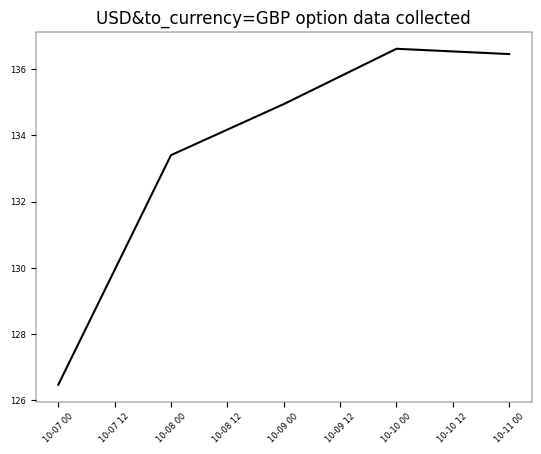

<Figure size 640x480 with 0 Axes>

In [4]:
demo_spots = spots[dates]
demo_spots.index = pd.to_datetime(demo_spots.index, format='%Y-%m-%d')
plt.figure()
plt.plot(demo_spots,color='black')
plt.title(f'{symbol} option data collected')
plt.xticks(rotation=45)
plt.show()
plt.clf()

# example calibraion

now why not select the one trading day and porceed with an example calibration of our Heston (1993) model

In [5]:
date = dates[2]
raw_data = chain[date]
calculation_datetime = datetime.strptime(date,'%Y-%m-%d')
calculation_date = ql.Date(
    calculation_datetime.day,
    calculation_datetime.month,
    calculation_datetime.year,
)
notebook_printdate = str(calculation_datetime.strftime('%A, '))+str(calculation_date)
print(notebook_printdate)

Wednesday, October 9th, 2024


## modelling the volatility surface

In [6]:
df = raw_data.copy()
df['volume'] = pd.to_numeric(df['volume'])
df['implied_volatility'] = pd.to_numeric(df['implied_volatility'])
df['strike'] = pd.to_numeric(df['strike'])
df['volume'] = pd.to_numeric(df['volume'])
df['expiration'] = pd.to_datetime(df['expiration'],format='%Y-%m-%d')
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')
df['days_to_maturity'] = df['expiration'] - df['date']
df['days_to_maturity'] = df['days_to_maturity'] / np.timedelta64(1, 'D')
df['days_to_maturity'] = df['days_to_maturity'].astype('int64')
df = df[(df['days_to_maturity']>=30)&(df['days_to_maturity']<=400)]
df = df[df['volume']>0].copy()
df['spot_price'] = spot
df['moneyness'] = ms.vmoneyness(df['spot_price'],df['strike'],df['type'])
df = df[(df['moneyness']<0)&(df['moneyness']>-0.5)]
indexed = df.copy().set_index(['strike','days_to_maturity'])

T = np.sort(df['days_to_maturity'].unique()).tolist()
K = np.sort(df['strike'].unique()).tolist()
volume_heatmap = pd.DataFrame(
    np.full((len(K), len(T)), np.nan), index=K, columns=T)
for k in K:
    for t in T:
        try:
            volume_heatmap.loc[k,t] = indexed.loc[(k,t),'volume']
        except Exception:
            pass
        
        
hottest_contracts = pd.DataFrame(
    volume_heatmap.unstack().sort_values(
        ascending=False)).head(50).reset_index()
hottest_contracts.columns = ['t','k','volume']
T = np.sort(hottest_contracts['t'].unique()).tolist()
K = np.sort(hottest_contracts['k'].unique()).tolist()

vol_matrix = pd.DataFrame(
    np.full((len(K),len(T)),np.nan),
    index = K,
    columns = T
)
for k in K:
    for t in T:
        try:
            vol_matrix.loc[k,t] = indexed.loc[(k,float(t)),'implied_volatility']
        except Exception:
            pass

vol_matrix = vol_matrix.dropna().copy()
T = vol_matrix.columns.tolist()
K = vol_matrix.index.tolist()

cols_to_map = [
        'contractID', 'symbol', 'expiration', 'type', 'last', 'mark',
        'bid', 'bid_size', 'ask', 'ask_size', 'volume', 'open_interest', 'date',
        'implied_volatility', 'delta', 'gamma', 'theta', 'vega', 'rho',
        'spot_price', 'moneyness'
]
for col in cols_to_map:
    for i,row in hottest_contracts.iterrows():
        hottest_contracts.at[i,col] = indexed.loc[(row['k'],row['t']),col]
        
hottest_contracts = hottest_contracts.rename(
    columns={'t':'days_to_maturity','k':'strike_price'}).copy()

KeyError: (np.float64(134.0), np.float64(37.0))

In [ ]:
s = float(df['spot_price'].unique()[0])
print(f"\n{symbol} spot price: {s}")
plot_vol_surface(vol_matrix)
vol_matrix

## calibrating a Heston (1993) model

In [ ]:
vol_matrix = vol_matrix.sort_index().drop_duplicates()
pd.to_numeric(raw_data['last'])
raw_data['date'] = pd.to_datetime(raw_data['date'])
raw_data['expiration'] = pd.to_datetime(raw_data['expiration'])
raw_data['implied_volatility'] = pd.to_numeric(raw_data['implied_volatility']).astype(float)
raw_data['strike'] = pd.to_numeric(raw_data['strike'])
raw_data['last'] = pd.to_numeric(raw_data['last'])
contract_maturities = np.array((raw_data['expiration'] - raw_data['date']) / timedelta(days=1)).astype(int)
raw_data['days_to_maturity'] = contract_maturities

T = vol_matrix.columns.tolist()
K = vol_matrix.index.tolist()
r = 0.04
g = 0.0

ql.Settings.instance().evaluationDate = calculation_date
flat_ts, dividend_ts = ms.ql_ts_rg(r, g, calculation_date)
S_handle = ql.QuoteHandle(ql.SimpleQuote(s))

heston_helpers = []
v0 = 0.01; kappa = 0.2; theta = 0.02; rho = -0.75; eta = 0.5;
process = ql.HestonProcess(
    flat_ts,
    dividend_ts,
    S_handle,
    v0,                # Initial volatility
    kappa,             # Mean reversion speed
    theta,             # Long-run variance (volatility squared)
    eta,               # Volatility of the volatility
    rho                # Correlation between asset and volatility
)
model = ql.HestonModel(process)
engine = ql.AnalyticHestonEngine(model)

for t in T:
    for k in K:
        p = ql.Period(int(t),ql.Days)
        volatility = vol_matrix.loc[k,t]
        helper = ql.HestonModelHelper(
            p, ms.calendar, float(s), k, 
            ql.QuoteHandle(ql.SimpleQuote(volatility)), 
            flat_ts, 
            dividend_ts
            )
        helper.setPricingEngine(engine)
        heston_helpers.append(helper)

lm = ql.LevenbergMarquardt(1e-8, 1e-8, 1e-8)


model.calibrate(heston_helpers, lm,
                  ql.EndCriteria(1000, 50, 1.0e-8,1.0e-8, 1.0e-8))

theta, kappa, eta, rho, v0 = model.params()
heston_parameters = pd.Series(
    [theta, kappa, eta, rho, v0],
    index = ['theta', 'kappa', 'eta', 'rho', 'v0'],
    dtype = float
)
calibration_test_data = raw_data.copy()[['strike','type','last','implied_volatility','days_to_maturity']]
calibration_test_data.columns = ['strike_price','w','market_price','volatility','days_to_maturity']
calibration_test_data['spot_price'] = s
calibration_test_data['risk_free_rate'] = r
calibration_test_data['dividend_rate'] = g
calibration_test_data = calibration_test_data[calibration_test_data['days_to_maturity'].isin(df['days_to_maturity'])]
calibration_test_data[heston_parameters.index.tolist()] = np.tile(heston_parameters,(calibration_test_data.shape[0],1))
calibration_test_data.loc[:,'moneyness'] = ms.vmoneyness(
    calibration_test_data['spot_price'].values,
    calibration_test_data['strike_price'].values,
    calibration_test_data['w'].values)
calibration_test_data['calculation_date'] = calculation_datetime
calibration_test_data['black_scholes'] = ms.vector_black_scholes(calibration_test_data)
calibration_test_data['heston_price'] = ms.vector_heston_price(calibration_test_data)

## testing calibration accuracy

In [ ]:
calibration_test_data.loc[:,'error'] = calibration_test_data['heston_price'].values - calibration_test_data['black_scholes'].values
avg = np.mean(np.abs(calibration_test_data['error']))
print(f"\n{printdate}\n{heston_parameters}\naverage absolute error: {round(avg,3)}")
print(f"calibration testing dataset:\n{calibration_test_data.describe()}")

# train data generation

In [ ]:
strike_spread = 0.2
strike_step = 5
K = np.arange(
    int(s*(1-strike_spread)),
    int(s*(1+strike_spread)),
    strike_step
).astype(int).tolist()

barrier_step = 10
down_barriers =  np.arange(
    s*0.5,
    s*0.99,
    barrier_step
).astype(int).tolist()

T = [
    30,60,90,
    180,360,540,720
]
print(f"\n{symbol} spot price:\n     {spot}\n\nstrikes:\n     {K}\n\nbarriers:\n     {down_barriers}\n\nmaturities:\n     {T}\n")

In [ ]:
print('generating contracts...')
features = pd.DataFrame(
    product(
        [spot],
        K,
        T,
        down_barriers,
        [0.0], # rebate
        ['put','call'],
        [0.04], # risk-free rate
        [0.0], # dividend rate
        [theta], 
        [kappa], 
        [eta], 
        [rho], 
        [v0],
        [calculation_datetime],
        ['Out','In']
    ),
    columns = [
        'spot_price',
        'strike_price',
        'days_to_maturity',
        'barrier',
        'rebate',
        'w',
        'risk_free_rate',
        'dividend_rate',
        'theta', 'kappa', 'eta', 'rho', 'v0',
        'calculation_date',
        'outin',
    ]
)
features['moneyness'] = ms.vmoneyness(features['spot_price'],features['strike_price'],features['w'])
features['barrier_type_name'] = 'Down' + features['outin']
print('contracts generated')
print(f'pricing {features.shape[0]} contracts...')
features['vanilla_price'] = ms.vector_heston_price(features)
features['barrier_price'] = ms.vector_barrier_price(features)
featuresby_t = features.copy().set_index('days_to_maturity')
print('priced!')

In [ ]:
for t in T:
    plt.figure(figsize=(3, 2), dpi=150)
    prices= featuresby_t.loc[t,'barrier_price']
    plt.hist(prices,bins=int(np.sqrt(prices.shape[0])))
    plt.tick_params(axis='both', which='major', length=1, width=1/3)  # Thinner tick marks
    plt.title(f'{t} day maturity', fontsize=fontsize)
    plt.show()
    plt.clf()

# model training

In [ ]:
import convsklearn
help(convsklearn)

In [ ]:
help(convsklearn.convsklearn)

In [ ]:
from convsklearn import target_name, numerical_features, categorical_features, transformers, target_transformer_pipeline

In [ ]:
barrier_trainer = convsklearn.convsklearn(
    target_name=target_name, 
    numerical_features=numerical_features, 
    categorical_features=categorical_features, 
    transformers=transformers, 
    target_transformer_pipeline=target_transformer_pipeline, 
    max_iter=1000
)

In [ ]:
features['observed_price'] = ms.noisyfier(features.loc[:,'barrier_price']) 
    # apply slight peturbation in the form of a random normal with standard deviation 0.15
train_data = features[features['days_to_maturity']!=720]
test_data = features[features['days_to_maturity']==720]
print(f"train data count: {train_data.shape[0]}")
print(f"test data count: {test_data.shape[0]}")
arrs = barrier_trainer.get_train_test_arrays(train_data,test_data)
train_X = arrs['train_X']
train_y = arrs['train_y']
test_X = arrs['test_X']
test_y = arrs['train_y']
preprocessor = barrier_trainer.preprocess()
dnn_barriers, runtime, specs = barrier_trainer.run_dnn(preprocessor, train_X, train_y)
in_sample, out_of_sample, errors = barrier_trainer.test_prediction_accuracy(dnn_barriers, test_data, train_data)
outsample = out_of_sample.rename(
    columns = {
        'strike_price':'k',
        'days_to_maturity':'t',
        'barrier_type_name':'type',
        'barrier_price':'price',
        'vanilla_price':'vanilla',
        'spot_price':'spot',
        'outofsample_target':'target', 
        'outofsample_prediction':'dnn', 
        'outofsample_error' : 'error',
        'barrier':'b'
        }
)
outsample = outsample[[
    'spot', 'k', 'b','price', 'vanilla', 'type', 'w','t', 
    'target', 'dnn', 'error'
]]
pd.set_option("display.float_format", "{:.2f}".format)
pd.set_option("display.max_rows",None)
print(f"\n{outsample.describe()}")
outsample_preview = outsample.copy().sort_values(by=['w','type','k','b'],ascending=False).reset_index(drop=True)
print(f"\n{symbol} down barrier options for {notebook_printdate}")
print(f"\n{outsample_preview}")
pd.reset_option("display.max_rows")
pd.reset_option("display.float_format") 